# Linear Discrimative Analysis

- Classification modeling: logistic regression (`statsmodels`) vs Linear Discrimative Analysis (`sklearn.discriminant_analysis`).


In [1]:
import numpy as np
import pandas as pd

### Data cleaning and transformation

In [2]:
churn = pd.read_csv("customerchurn.csv")
churn.info()
churn

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            7032 non-null   int64  
 1   MonthlyCharges   7032 non-null   float64
 2   SeniorCitizen    7032 non-null   int64  
 3   PaymentMethod    7032 non-null   object 
 4   InternetService  7032 non-null   object 
 5   tenure           7032 non-null   int64  
 6   Contract         7032 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 384.7+ KB


,Churn,MonthlyCharges,SeniorCitizen,PaymentMethod,InternetService,tenure,Contract
0,0,29.85,0,Electronic check,DSL,1,Month-to-month
1,0,56.95,0,Mailed check,DSL,34,One year
2,1,53.85,0,Mailed check,DSL,2,Month-to-month
3,0,42.30,0,Bank transfer,DSL,45,One year
4,1,70.70,0,Electronic check,Fiber optic,2,Month-to-month
...,...,...,...,...,...,...,...
7027,0,84.80,0,Mailed check,DSL,24,One year
7028,0,103.20,0,Credit card,Fiber optic,72,One year
7029,0,29.60,0,Electronic check,DSL,11,Month-to-month
7030,1,74.40,1,Mailed check,Fiber optic,4,Month-to-month


In [3]:
from sklearn.model_selection import train_test_split
churn_train, churn_test = train_test_split(churn, test_size=0.3, random_state=88)
churn_train.shape, churn_test.shape

((4922, 7), (2110, 7))

In [4]:
# As p-values of PaymentMethod Credit Card and PaymentMethodMailed check are very large (0.403 and 0.731), let's remove them.

# How do we do this? Create a new feature (dummy variable).

churn_train2 = churn_train.copy()
# print(churn_train2.head())
churn_train2['ElectronicCheck'] = (churn_train2['PaymentMethod'] == 'Electronic check').astype('int64')
# print(churn_train2.head())
churn_train2.drop(columns=['PaymentMethod'], inplace=True)

# Let's do the same for test set as well

churn_test2 = churn_test.copy()
churn_test2['ElectronicCheck'] = (churn_test2['PaymentMethod'] == 'Electronic check').astype('int64')
churn_test2.drop(columns=['PaymentMethod'], inplace=True)

churn_test2.head()

,Churn,MonthlyCharges,SeniorCitizen,InternetService,tenure,Contract,ElectronicCheck
2839,1,99.60,1,Fiber optic,4,Month-to-month,1
4965,0,93.80,1,Fiber optic,13,Month-to-month,0
6686,0,96.55,0,Fiber optic,5,Month-to-month,1
4151,0,25.20,0,No,39,Two year,0
241,0,109.20,0,Fiber optic,72,Two year,0


In [5]:
y_train = churn_train2['Churn']
X_train = churn_train2.drop(['Churn'], axis=1)

y_test = churn_test2['Churn']
X_test = churn_test2.drop(['Churn'], axis=1)

In [7]:
import statsmodels.formula.api as smf
logreg3 = smf.logit(formula = 'Churn ~ SeniorCitizen + ElectronicCheck + InternetService + tenure + Contract',
                       data = churn_train2).fit()
print(logreg3.summary())
# 1. Predicting the probability of default
y_prob = logreg3.predict(churn_test2)

# 2. Determining the optimal threshold of the default probability
## price reduction = 800 and no price reduction = 1000
## 800 (1 - p/2) = 1000 (1 - p) -> Break-even point: p = 0.333 (Slides 23-24, Lecture 11).
## The threshold of high churn-risk and low churn-risk is 0.333.
## If p > 1/3, then we consider high churn-risk and give them the price reduction because
## our expected profit for no price reduction > expected profit for price reduction

# 3. Predicting the label
y_pred = pd.Series([1 if x > 1/3 else 0 for x in y_prob], index=y_prob.index)

Optimization terminated successfully.
         Current function value: 0.422336
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4914
Method:                           MLE   Df Model:                            7
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                  0.2687
Time:                        21:43:33   Log-Likelihood:                -2078.7
converged:                       True   LL-Null:                       -2842.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.6254      0.085     -7.363     

### Preliminary: one-hot encoding

In [8]:
from sklearn.preprocessing import OneHotEncoder
?OneHotEncoder

In [9]:
# initialize the OneHotEncoder
drop_enc = OneHotEncoder(drop='first').fit(X_train[['InternetService','Contract']])
print(drop_enc.categories_)

[array(['DSL', 'Fiber optic', 'No'], dtype=object), array(['Month-to-month', 'One year', 'Two year'], dtype=object)]


In [10]:
# Perform the transformation for both the training and the test set.

# InternetService: Fiber optic/DSL/No || Contract: Month-to-month/One year/Two year
X_train_categorical = drop_enc.transform(X_train[['InternetService','Contract']]).toarray()
print(X_train_categorical.shape)  # 4 columns

X_train_numerical = X_train[['MonthlyCharges','SeniorCitizen','tenure']].values

# combine the numerical variables and the one-hot encoded categorical variables
X_train_transformed = np.concatenate((X_train_numerical,X_train_categorical), axis = 1)
print(X_train_transformed.shape)
print(X_train_transformed[:5])

# Do the same for test data
X_test_categorical = drop_enc.transform(X_test[['InternetService','Contract']]).toarray()
X_test_numerical = X_test[['MonthlyCharges','SeniorCitizen','tenure']].values
X_test_transformed = np.concatenate((X_test_numerical,X_test_categorical), axis = 1)

(4922, 4)
(4922, 7)
[[101.15   0.     8.     1.     0.     0.     0.  ]
 [ 70.15   1.    38.     0.     0.     1.     0.  ]
 [ 79.6    0.    70.     0.     0.     0.     1.  ]
 [ 19.5    0.    14.     0.     1.     1.     0.  ]
 [ 53.6    0.    24.     0.     0.     0.     0.  ]]


### Model Fitting and Prediction Making

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


lda = LinearDiscriminantAnalysis()
lda.fit(X_train_transformed, y_train)

y_prob_lda = lda.predict_proba(X_test_transformed)
print(y_prob_lda) # col0: prob(Y=0), col1: prob(Y=1)
y_pred_lda = pd.Series([1 if x > 1/3 else 0 for x in y_prob_lda[:,1]], index=y_prob.index)

cm = confusion_matrix(y_test, y_pred_lda)
print ("Confusion Matrix: \n", cm)
print ("\nAccuracy:", accuracy_score(y_test, y_pred_lda))

[[0.22888549 0.77111451]
 [0.27701745 0.72298255]
 [0.34620774 0.65379226]
 ...
 [0.92409787 0.07590213]
 [0.36967937 0.63032063]
 [0.77828984 0.22171016]]
Confusion Matrix: 
 [[1206  336]
 [ 163  405]]

Accuracy: 0.7635071090047393


### Plot the ROC Curve

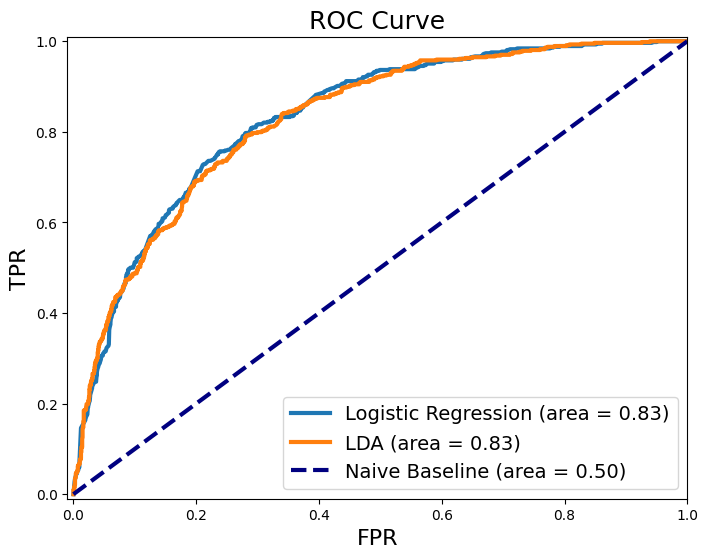

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob) # FPR, TPR, thresholds
roc_auc = auc(fpr, tpr)

fpr_lda, tpr_lda, _ = roc_curve(y_test, y_prob_lda[:,1])
roc_auc_lda = auc(fpr_lda, tpr_lda)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot(fpr_lda, tpr_lda, lw=3, label='LDA (area = {:0.2f})'.format(roc_auc_lda))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()